<a href="https://colab.research.google.com/github/YudaiFukushige/PINN_Hydraulics/blob/main/PINN_1DOpenChannelFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

$h, u = f_{NN}\left(x, t\right)$ となる $f_{NN}$ を学習する

# 問題設定

- 水路の形状
    - 勾配 : 1/1000
    - 横断面 : 矩形
    - 水路幅 : 1 m
    - 粗度係数 : 0.015
- 計算条件
    - $x \in [0, 200]$
        - 上流側が，0
    - $t \in [0, 200]$
    - 初期条件
        - 等流で流れているように設定する
        - $h(x, t = 0) = 1.0$
        - $u(x, t = 0) = 1.014$
    - 境界条件
        - 上流 : 流速
            - $u(x = 0, t) = 1.014$
        - 下流 : 水深
            - $h(x = 1000, t) = 1.0, t \in [0, 5)$
            - $h(x = 1000, t) = 0.2 \times t, t \in [5, 6)$
            - $h(x = 1000, t) = 1.2, t \in [6, 200]$

# Loss functions

In [3]:
criteria = nn.MSELoss()

## Physics informed loss

In [4]:
def physics_informed_loss_mass(x, t, net):
    """
    連続式に関するPhysics informed lossを計算する関数
    x : 空間
    t : 時間
    net : (x, t)を受け取って，(h, u)を返すネットワーク
    """
    # 予測値を計算
    h = net(x, t)[:, 0]
    u = net(x, t)[:, 1]
    # 水深 h の x による1階偏微分
    h_x = torch.autograd.grad(
        h, x,
        grad_outputs=torch.ones_like(h),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]
    # 水深 h の t による1階偏微分
    h_t = torch.autograd.grad(
        h, t,
        grad_outputs=torch.ones_like(h),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]
    # 流速 u の x による1階偏微分
    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]
    # Physics informed loss
    pinn_loss_mass = h_t + u*h_x + h*u_x
    zeros_t = torch.zeros(pinn_loss_mass.size()).to(device)
    pinn_loss_mass_ = criteria(pinn_loss_mass, zeros_t)
    return pinn_loss_mass_

In [5]:
def physics_informed_loss_momentum(x, t, net, i0, B, n):
    """
    運動方程式に関するPhysics informed lossを計算する関数
    x : 空間
    t : 時間
    i0 : 勾配
    B : 水路幅
    n : マニングの粗度係数
    net : (x, t)を受け取って，(h, u)を返すネットワーク
    """
    # 予測値を計算
    h = net(x, t)[:, 0]
    u = net(x, t)[:, 1]
    # 水深 h の x による1階偏微分
    h_x = torch.autograd.grad(
        h, x,
        grad_outputs=torch.ones_like(h),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]
    # 流速 u の x による1階偏微分
    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]
    # 流速 u の t による1階偏微分
    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]
    # 径深
    R = culclate_hydraulic_radius(h=h, B=B)
    # 摩擦損失高
    friction_term = (n**2 * u**2) / R**(4/3)

    # Physics informed loss
    pinn_loss_momentum = -i0 + h_x + (1/9.8)*u_x + friction_term + (1/9.8)*u_t
    zeros_t = torch.zeros(pinn_loss_momentum.size()).to(device)
    pinn_loss_momentum_ = criteria(pinn_loss_momentum, zeros_t)
    return pinn_loss_momentum_

In [6]:
def culclate_hydraulic_radius(h, B=1.0):
    """
    一様な矩形水路の径深を計算する
    """
    return B + 2.0*h

## Initial condition

In [7]:
def initial_condition_loss(x, t, net, h_ini, u_ini):
    # 予測値を計算
    h = net(x, t)[:, 0]
    u = net(x, t)[:, 1]
    # h, u それぞれの initial condition loss を計算する
    h_ini_condition_loss = criteria(h, h_ini)
    u_ini_condition_loss = criteria(u, u_ini)
    return h_ini_condition_loss + u_ini_condition_loss

In [8]:
ini_sample_size = 2000
x_ini = np.linspace(0.0, 1000.0, ini_sample_size)
X_ini = np.zeros([ini_sample_size, 2]) # (x, t)の順
X_ini[:, 0] = x_ini
hu_ini = np.ones([ini_sample_size, 2]) # (h, u)の順, ここ，h と u で分けた方がいい，かも
hu_ini[:, 1] = 1.014

X_ini_t = torch.tensor(X_ini, requires_grad=True).float().to(device)
hu_ini_t = torch.tensor(hu_ini, requires_grad=True).float().to(device)

## Boundary condition

In [9]:
# 上下流で境界条件となる変数が異なるので，変数ごとに分ける（統一してもよいか？？）
def boundary_condition_loss_h(x, t, net, h_bnd):
    # 予測値を計算
    h = net(x, t)[:, 0]
    # h, u それぞれの boundary condition loss を計算する
    h_bnd_condition_loss = criteria(h, h_bnd)
    return h_bnd_condition_loss

def boundary_condition_loss_u(x, t, net, u_bnd):
    # 予測値を計算
    u = net(x, t)[:, 1]
    # h, u それぞれの boundary condition loss を計算する
    u_bnd_condition_loss = criteria(u, u_bnd)
    return u_bnd_condition_loss

In [10]:
bnd_sample_size = 200
t_bnd = np.linspace(0.0, 200.0, bnd_sample_size)

#
# x = 0.0 (上流側)
#
X_bnd1 = np.zeros([bnd_sample_size, 2]) # (x, t)の順
X_bnd1[:, 1] = t_bnd
# 上流側は，流量条件
u_bnd = np.ones([bnd_sample_size]) * 1.014

#
# x = 1000.0 (下流側)
#
X_bnd2 = np.zeros([bnd_sample_size, 2]) # (x, t)の順
X_bnd2[:, 0] = 1000.0
X_bnd2[:, 1] = t_bnd
# 下流側は，水深条件
h_bnd = np.zeros([bnd_sample_size])
h_bnd[t_bnd<5.0] = 1.0
h_bnd[(t_bnd>=5.0) & (t_bnd<6.0)] = 0.2*t_bnd[(t_bnd>=5.0) & (t_bnd<6.0)]
h_bnd[t_bnd>=6.0] = 1.2

# tensor化
X_bnd1_t = torch.tensor(X_bnd1, requires_grad=True).float().to(device)
u_bnd_t = torch.tensor(u_bnd, requires_grad=True).float().to(device).unsqueeze(dim=1)
X_bnd2_t = torch.tensor(X_bnd2, requires_grad=True).float().to(device)
h_bnd_t = torch.tensor(h_bnd, requires_grad=True).float().to(device).unsqueeze(dim=1)

## 時空間のランダムサンプリング

Udemy講座のほぼコピペ

In [11]:
# サンプリングポイント
x_ = np.linspace(0.0, 1000.0, 100)
t_ = np.linspace(0.0, 20.0, 100)
X, T = np.meshgrid(x_, t_, indexing="ij") # 1次元 => 2次元
x_flat = X.flatten()
t_flat = T.flatten()

# サンプルサイズ
sampling_size = 5000
random_idx = np.random.choice(np.arange(x_flat.shape[0]), size=sampling_size, replace=False) # indexのランダムサンプリング, 0〜len(x_flat)のサイコロを5000回振る

# サンプリングの実行
x_sampled = x_flat[random_idx]
t_sampled = t_flat[random_idx]
# サンプリングした(x, t)座標の格納
X_sampled = np.zeros([sampling_size, 2])
X_sampled[:, 0] = x_sampled
X_sampled[:, 1] = t_sampled
X_sample_t = torch.tensor(X_sampled, requires_grad=True).float().to(device)

# MLPモデルの設計

In [12]:
class PINN(torch.nn.Module):
    def __init__(self, activation="relu"): # 活性化関数を設定できるようにしておく
        super().__init__()
        self.regressor = nn.Linear(5, 2) # 出力層．出力はuだけなので，1
        self.activation = activation
        self.linear1 = self.linear(2, 5, activation=self.activation) # x, tを入力するので，入力次元は２．初期化の中で，下で定義したメソッドを参照できるんだ
        self.linear2 = self.linear(5, 20, activation=self.activation)
        self.linear3 = self.linear(20, 40, activation=self.activation)
        self.linear4 = self.linear(40, 40, activation=self.activation)
        self.linear5 = self.linear(40, 40, activation=self.activation)
        self.linear6 = self.linear(40, 20, activation=self.activation)
        self.linear7 = self.linear(20, 10, activation=self.activation)
        self.linear8 = self.linear(10, 5, activation=self.activation)

    def linear(self, in_features, out_features, activation="relu"):
        layers = [nn.Linear(in_features, out_features)]
        # 活性化関数による分岐
        if activation=="relu":
            layers.append(nn.Relu(inplace=True))
        elif activation=="tanh":
            layers.append(nn.Tanh())
        else:
            layers.append(nn.Sigmoid())
        net = nn.Sequential(*layers) # listを展開して，全結合層と活性化関数を一列に繋げたプロセスの作成
        return net

    def forward(self, x, t):
        inputs = torch.cat([x, t], axis=1) # x, tを1つのtensorにまとめる
        out = self.linear1(inputs)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.linear4(out)
        out = self.linear5(out)
        out = self.linear6(out)
        out = self.linear7(out)
        out = self.linear8(out)
        out = self.regressor(out)
        return out

# 学習

In [13]:
net = PINN(activation="tanh").to(device) #　インスタンスの作成
optimizer = optim.Adam(net.parameters(), lr=0.0005) # 最適化にはAdamを使用

In [ ]:
num_epochs = 9000
for epoch in range(num_epochs):
    optimizer.zero_grad() # 溜まった勾配を初期化
    #
    # PINN Loss
    #
    x_sampled = X_sample_t[:, 0].unsqueeze(dim=-1).to(device)
    t_sampled = X_sample_t[:, 1].unsqueeze(dim=-1).to(device)
    pinn_loss_mass = physics_informed_loss_mass(x_sampled, t_sampled, net)
    pinn_loss_momentum = physics_informed_loss_momentum(x_sampled, t_sampled, net, i0=1/1000, B=1.0, n=0.015)
    #
    # Initial Loss
    #
    x_ini = X_ini_t[:, 0].unsqueeze(dim=-1).to(device)
    t_ini = X_ini_t[:, 1].unsqueeze(dim=-1).to(device)
    ini_loss = initial_condition_loss(x_ini, t_ini, net, hu_ini_t[:, 0], hu_ini_t[:, 1])
    #
    # Boundary loss
    #
    # 上流
    x_bnd1 = X_bnd1_t[:, 0].unsqueeze(dim=-1).to(device)
    t_bnd1 = X_bnd1_t[:, 1].unsqueeze(dim=-1).to(device)
    bnd_loss1 = boundary_condition_loss_u(x_bnd1, t_bnd1, net, u_bnd_t)
    # 下流
    x_bnd2 = X_bnd2_t[:, 0].unsqueeze(dim=-1).to(device)
    t_bnd2 = X_bnd2_t[:, 1].unsqueeze(dim=-1).to(device)
    bnd_loss2 = boundary_condition_loss_h(x_bnd1, t_bnd1, net, h_bnd_t)

    loss = pinn_loss_mass + pinn_loss_momentum + ini_loss + bnd_loss1 + bnd_loss2
    loss.backward() # 誤差逆伝播
    optimizer.step() # パラメーター更新
    if epoch%500==0:
        loss_ = loss.item()
        pinn_loss_mass_ = pinn_loss_mass.item()
        pinn_loss_momentum_ = pinn_loss_momentum.item()
        ini_loss_ = ini_loss.item()
        bnd_loss1_ = bnd_loss1.item()
        bnd_loss2_ = bnd_loss2.item()
        print(f"epoch : {epoch:.3e}, loss : {loss_:.2e}, pinn_mass : {pinn_loss_mass_:.2e}, pinn_momentum : {pinn_loss_momentum_:.2e} ini : {ini_loss_:.2e}, bnd1 : {bnd_loss1_:.2e}, bnd2 : {bnd_loss2_:.2e}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch : 0.000e+00, loss : 4.85e+00, pinn_mass : 8.95e-10, pinn_momentum : 9.93e-07 ini : 2.21e+00, bnd1 : 1.27e+00, bnd2 : 1.36e+00
epoch : 5.000e+02, loss : 2.96e-02, pinn_mass : 1.13e-09, pinn_momentum : 8.97e-07 ini : 7.65e-04, bnd1 : 4.97e-06, bnd2 : 2.89e-02
epoch : 1.000e+03, loss : 2.00e-02, pinn_mass : 7.28e-10, pinn_momentum : 9.04e-07 ini : 9.36e-03, bnd1 : 9.57e-09, bnd2 : 1.06e-02
epoch : 1.500e+03, loss : 2.00e-02, pinn_mass : 3.82e-10, pinn_momentum : 9.04e-07 ini : 9.40e-03, bnd1 : 1.18e-08, bnd2 : 1.06e-02
epoch : 2.000e+03, loss : 1.99e-02, pinn_mass : 8.57e-11, pinn_momentum : 9.04e-07 ini : 9.39e-03, bnd1 : 5.90e-08, bnd2 : 1.05e-02
epoch : 2.500e+03, loss : 4.73e-03, pinn_mass : 8.29e-07, pinn_momentum : 3.66e-06 ini : 1.72e-03, bnd1 : 1.02e-03, bnd2 : 1.98e-03
epoch : 3.000e+03, loss : 1.24e-03, pinn_mass : 3.55e-07, pinn_momentum : 4.29e-06 ini : 6.07e-05, bnd1 : 1.70e-05, bnd2 : 1.16e-03
epoch : 3.500e+03, loss : 1.18e-03, pinn_mass : 2.31e-07, pinn_momentum : 4.

In [65]:
X_test = np.zeros([x_flat.shape[0], 2])
X_test[:, 0] = x_flat
X_test[:, 1] = t_flat

X_test_t = torch.tensor(X_test).float().to(device)
x_test = X_test_t[:, 0].unsqueeze(dim=-1)
t_test = X_test_t[:, 1].unsqueeze(dim=-1)
h_pred = net(x_test, t_test)[:, 0]

h_pred_arr = h_pred.detach().cpu().numpy().reshape(100, 100)

<Axes: title={'center': 'PINN'}>

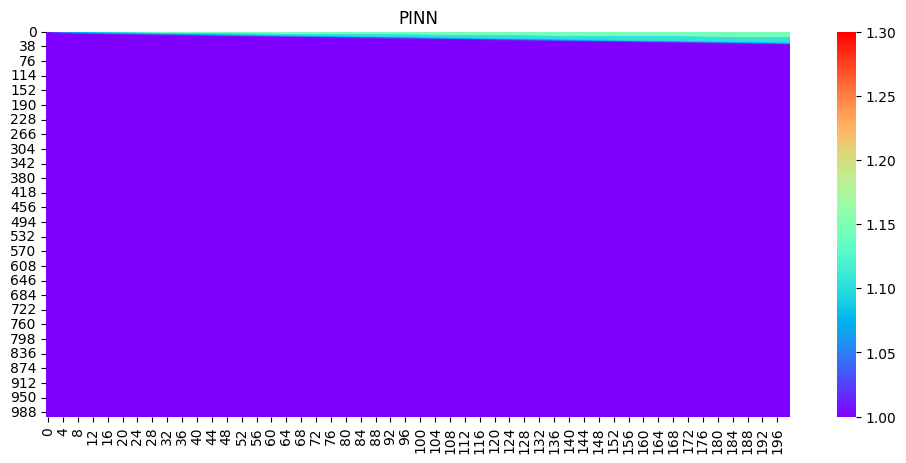

In [75]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)
plt.title('PINN')
sns.heatmap(h_pred_arr, cmap='rainbow', vmin=1.0, vmax=1.3)